The main objective practice time series with Python and to show why ARIMA isn't suitable to predict stock prices

April 2021

In [25]:
#Important libraries and modules

import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
import pandas_datareader.data as web
%matplotlib inline

In [26]:
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2021,4,20)

In [27]:
disney = web.DataReader('DIS','yahoo',start,end)

df_length = len(disney)

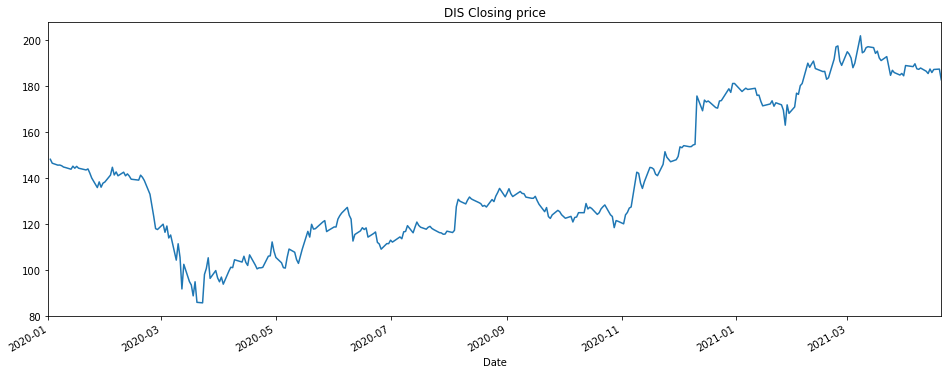

In [28]:
#Disney´s stock price at the time of its closing within the given period
disney['Close'].plot(figsize = (16,6), 
                     xlim = [start,end], 
                     title = 'DIS Closing price');

In [29]:
#Decomposing the data to better see the trend, seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

In [30]:
decomp = seasonal_decompose(disney['Close'], period = 12)

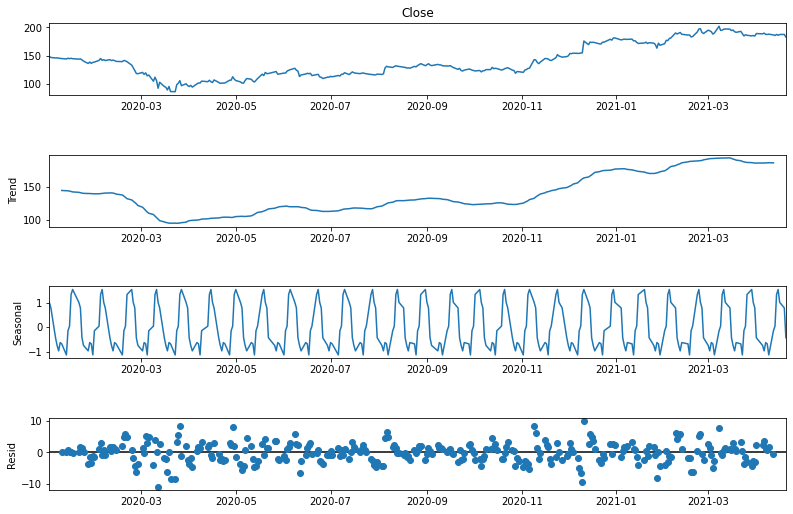

In [31]:
fig = decomp.plot()
fig.set_size_inches(12, 8)

In [32]:
#Augmented Dickey-Fuller mathematical module to check if the time series is stationary
from statsmodels.tsa.stattools import adfuller

In [33]:
#The results are not easy to read on the format presented directly from the adfuller function and due to this fact,
#the function below was created to make a better interpretation

def adf_check(time_series):
    
    result = adfuller(time_series)
    
    print('Augmented Dickey-Fuller Test')
    
    labels = ['ADS Test Statistic', 'p value', 'Number of lags','Number observations used']
    
    for value,label in zip(result, labels):
        print(label + ' : '+ str(value))
    
    if result[1] <= 0.05:
        print('Strong evidence against null hypothesis')
        print('Reject null hypothesis')
        print('Data has no unit root and is stationary')
    
    else:
        print('Weak evidence against null hypothesis')
        print('Failure to reject the null hypothesis')
        print('Data has a unit root and is non-stationary')

In [34]:
#It is visible from the decomposing graphics that the data is non-stationary and therefore we will need to differentiate

adf_check(disney['Close'])

Augmented Dickey-Fuller Test
ADS Test Statistic : -0.3198240918274965
p value : 0.9226493422410734
Number of lags : 1
Number observations used : 325
Weak evidence against null hypothesis
Failure to reject the null hypothesis
Data has a unit root and is non-stationary


In [35]:
#Since the data is non-stationary it is necessary to differentiate it at least once

disney['First Diff'] = disney['Close'] - disney['Close'].shift(1)

In [36]:
#After the 1st differentiation the time series is stationary. The NaN values must be eliminated from the data frame

adf_check(disney['First Diff'].dropna())

Augmented Dickey-Fuller Test
ADS Test Statistic : -21.28473297163512
p value : 0.0
Number of lags : 0
Number observations used : 325
Strong evidence against null hypothesis
Reject null hypothesis
Data has no unit root and is stationary


In [37]:
#ACF and PACF graphs
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

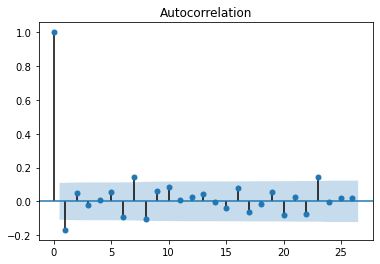

In [38]:
#Plotting the ACF where a significant correlation at lag 1 that decreases after a few lags is visible and obvious.
#This pattern indicates an autoregressive term. 
#We should use the partial autocorrelation function to determine the order of the autoregressive term.

acf = plot_acf(disney['First Diff'].dropna())

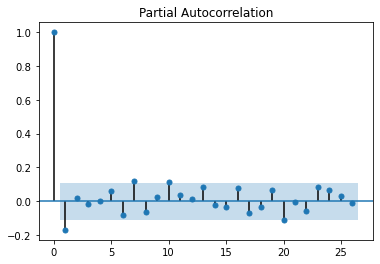

In [39]:
#Plotting the PACF graph

pacf = plot_pacf(disney['First Diff'].dropna())

In [40]:
#Applying the ARIMA model

#Since it took only one differentiation to get the data as stationary, D = 1

#This is a theoretical exercise and the P will be taken from a empirical observation of the PACF graph. It is clear
#that within 1 lag the AR is significant and I will take P = 1

#To avoid the potential for incorrectly specifying the MA order 
#(in the case where the MA is first tried then the MA order is being set to 0), 
#it may often make sense to extend the lag observed from the last significant term in the PACF.

In [41]:
disney.index

DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2021-04-07', '2021-04-08', '2021-04-09', '2021-04-12',
               '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
               '2021-04-19', '2021-04-20'],
              dtype='datetime64[ns]', name='Date', length=327, freq=None)

In [42]:
# For non-seasonal data
from statsmodels.tsa.arima_model import ARIMA

In [58]:
#Applying the ARIMA model 
results = ARIMA(disney['Close'].dropna(), order = (1,1,0) )

C:\Users\Utilizador\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Utilizador\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Here we start to encounter the issues with the application of the ARIMA model for stock price forecasting. The fact that the frequency is irregular due to weekends, non-trading days the model will not work properly

In [59]:
model = results.fit()

C:\Users\Utilizador\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


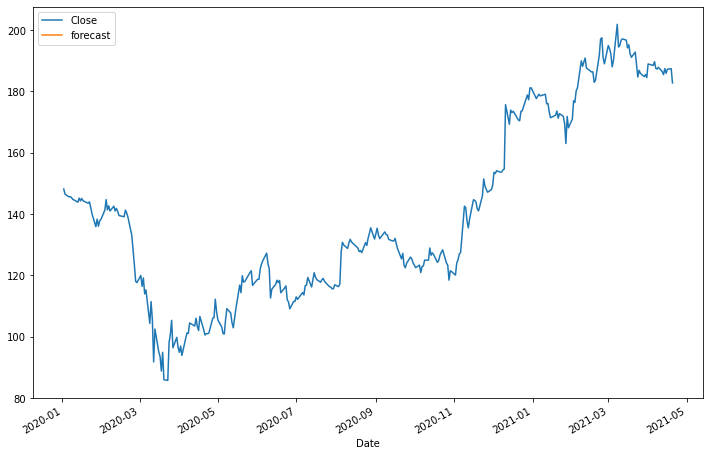

In [60]:
#Future values forecast but still within the given periods

disney['forecast'] = model.predict(start = 200, end = df_length)
disney[['Close','forecast']].plot(figsize = (12,8));